## Comparisson of XGBoostRegressor and Linear Regression for predicting Relative CPU Performance Data
### ... and some analytical notes

#### Preface
XGBoost keeps getting more and more recognition as a very powerful algorithm that is able to provide power-ful models. A lot of the parameters and behavior assimilates Linear Regression - except for the obvious fact that it uses gradient boosting via tree regressors -. I aim to understand better the ins-and-outs of the XGBoost algorithm, compare it to the Linear Regression (and Ridge Regression), and apply it to a real world dataset.

#### Feldmesser,Jacob. (1987). Computer Hardware. UCI Machine Learning Repository. https://doi.org/10.24432/C5830D.
 
"Relative CPU Performance Data, described in terms of its cycle time, memory size, etc."

In [2]:
import pandas as pd
from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
computer_hardware = fetch_ucirepo(id=29) 

# data (as pandas dataframes) 
df = computer_hardware.data.features 
y = computer_hardware.data.targets 


df

,VendorName,ModelName,MYCT,MMIN,MMAX,CACH,CHMIN,CHMAX,PRP,ERP
0,adviser,32/60,125,256,6000,256,16,128,198,199
1,amdahl,470v/7,29,8000,32000,32,8,32,269,253
2,amdahl,470v/7a,29,8000,32000,32,8,32,220,253
3,amdahl,470v/7b,29,8000,32000,32,8,32,172,253
4,amdahl,470v/7c,29,8000,16000,32,8,16,132,132
...,...,...,...,...,...,...,...,...,...,...
204,sperry,80/8,124,1000,8000,0,1,8,42,37
205,sperry,90/80-model-3,98,1000,8000,32,2,8,46,50
206,sratus,32,125,2000,8000,0,2,14,52,41
207,wang,vs-100,480,512,8000,32,0,0,67,47


In [3]:
computer_hardware.variables 

,name,role,type,demographic,description,units,missing_values
0,VendorName,Feature,Categorical,None,"(adviser, amdahl,apollo, basf, bti, burroughs,...",None,no
1,ModelName,Feature,Categorical,None,many unique symbols,None,no
2,MYCT,Feature,Integer,None,machine cycle time,nanoseconds,no
3,MMIN,Feature,Integer,None,minimum main memory,kilobytes,no
4,MMAX,Feature,Integer,None,maximum main memory,kilobytes,no
5,CACH,Feature,Integer,None,cache memory,kilobytes,no
6,CHMIN,Feature,Integer,None,minimum channels,units,no
7,CHMAX,Feature,Integer,None,maximum channels,units,no
8,PRP,Feature,Integer,None,published relative performance,None,no
9,ERP,Feature,Integer,None,estimated relative performance from the origin...,None,no


This dataset was obtained from the UCI dataset repository. Later in this notebook I will be discussing the dataset more in depth, and commenting on Feldmesser's findings. Initially, here is some insight to the data.

In [4]:
df.describe()

,MYCT,MMIN,MMAX,CACH,CHMIN,CHMAX,PRP,ERP
count,209.000000,209.000000,209.000000,209.000000,209.000000,209.000000,209.000000,209.000000
mean,203.822967,2867.980861,11796.153110,25.205742,4.698565,18.267943,105.622010,99.330144
std,260.262926,3878.742758,11726.564377,40.628722,6.816274,25.997318,160.830733,154.757102
min,17.000000,64.000000,64.000000,0.000000,0.000000,0.000000,6.000000,15.000000
25%,50.000000,768.000000,4000.000000,0.000000,1.000000,5.000000,27.000000,28.000000
50%,110.000000,2000.000000,8000.000000,8.000000,2.000000,8.000000,50.000000,45.000000
75%,225.000000,4000.000000,16000.000000,32.000000,6.000000,24.000000,113.000000,101.000000
max,1500.000000,32000.000000,64000.000000,256.000000,52.000000,176.000000,1150.000000,1238.000000


Right of the bat we can see that the scale for the features MYCT and MMIN is considerably larger than on other features. This can cause problems when fitting the data to the training set and making predictions on the test set. Some of the reasons include:

- Algorithms that use gradient descent suffer whenever features with higher scale influence the learning process negatively. This can lead to the model focusing mainly on features with a larger scale.

- Similarly, algorithms that use gradient descent may suffer from larger gradient steps and a possible slower convergence when dealing with large numbers.

- Regulatization (which we plan to implement) might affect different features disproportionately and unfairly based on their scale. This can lead to poor model preformance.

- For interpretability reasons, smaller numbers are easier to deal with, and insights on data are easier to derive when dealing with normalized data.

For this reason I will be normalizing the data. That being said, at first I want to train and test the algorithms with these default values, to understand the differences on how these algorithms react to features with larger scales.

In [5]:
df.info

<bound method DataFrame.info of     VendorName      ModelName  MYCT  MMIN   MMAX  CACH  CHMIN  CHMAX  PRP  ERP
0      adviser          32/60   125   256   6000   256     16    128  198  199
1       amdahl         470v/7    29  8000  32000    32      8     32  269  253
2       amdahl        470v/7a    29  8000  32000    32      8     32  220  253
3       amdahl        470v/7b    29  8000  32000    32      8     32  172  253
4       amdahl        470v/7c    29  8000  16000    32      8     16  132  132
..         ...            ...   ...   ...    ...   ...    ...    ...  ...  ...
204     sperry           80/8   124  1000   8000     0      1      8   42   37
205     sperry  90/80-model-3    98  1000   8000    32      2      8   46   50
206     sratus             32   125  2000   8000     0      2     14   52   41
207       wang         vs-100   480   512   8000    32      0      0   67   47
208       wang          vs-90   480  1000   4000     0      0      0   45   25

[209 rows x 10 colu

#### Nessesary Libraries:

In [8]:
import numpy as np
import xgboost as xgb


from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from scipy.stats import uniform, randint

In [9]:
y=df['PRP']

In [10]:
X = df.drop(columns=['VendorName','ModelName','ERP','PRP'], axis=1)

In [11]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

A simple 70%/30% split is good for now. Later on we will perform K-fold crossvalidation

In [12]:
seed = 7
test_size = 0.3
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=seed)

At first I will be using the following hyperparameters. Later on I will be performing hypterparameter optimization.

In [13]:
model = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.3, learning_rate = 0.1,
             max_depth = 5, alpha = 10, n_estimators = 10)

In [14]:
model.fit(X_train, y_train)

XGBRegressor(alpha=10, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.3, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=10, n_jobs=None,
             num_parallel_tree=None, ...)

I will be using Root Mean Squared Error for this analysis at first. Later on I might explore with different error metrics. 

In [15]:
import numpy as np

train_predictions = model.predict(X_train)
train_rmse = np.sqrt(mean_squared_error(y_train, train_predictions))

test_predictions = model.predict(X_test)
test_rmse = np.sqrt(mean_squared_error(y_test, test_predictions))

print("Train set RMSE: %f" % (train_rmse))
print("Test set RMSE: %f" % (test_rmse))

Train set RMSE: 90.384021
Test set RMSE: 122.071298


In [16]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV

In [17]:
# Cross-Validation for XGBoost
scores = cross_val_score(model, X, y, cv=5, scoring='neg_mean_squared_error')
print("XGBoost Cross-validated RMSE: ", np.sqrt(-scores.mean()))

XGBoost Cross-validated RMSE:  117.23734683492874


In [18]:
# Hyperparameter grid
param_dist = {
    'n_estimators': randint(50, 200),
    'learning_rate': uniform(0.01, 0.2),
    'max_depth': randint(3, 10),
    'colsample_bytree': uniform(0.3, 0.7),
    'alpha': uniform(0, 10)
}

# Randomized Search
rand_search = RandomizedSearchCV(model, param_distributions=param_dist, n_iter=25, scoring='neg_mean_squared_error', cv=3, verbose=1, n_jobs=-1, random_state=42)
rand_search.fit(X_train, y_train)

# Best Parameters and RMSE
print("Best Parameters: ", rand_search.best_params_)
best_rmse = np.sqrt(-rand_search.best_score_)
print("Best RMSE: ", best_rmse)


Fitting 3 folds for each of 25 candidates, totalling 75 fits
Best Parameters:  {'alpha': 9.26300878513349, 'colsample_bytree': 0.755753917851361, 'learning_rate': 0.19299193510875617, 'max_depth': 3, 'n_estimators': 121}
Best RMSE:  83.94860597179215


In [19]:
from sklearn.linear_model import LinearRegression

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

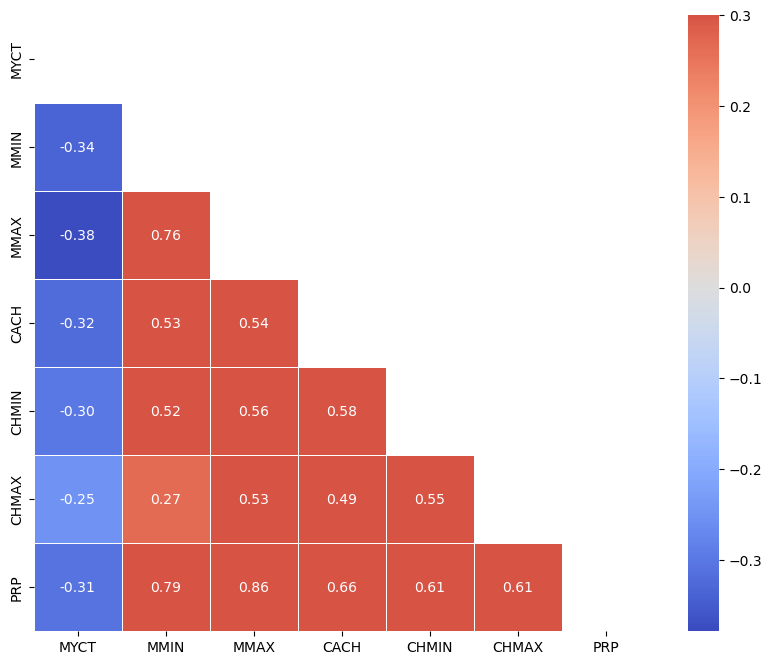

In [21]:
# Compute the correlation matrix
corr_matrix = df.drop(columns=['VendorName','ModelName','ERP']).corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# Set up the matplotlib figure
plt.figure(figsize=(10, 8))

# Draw the heatmap with the mask
sns.heatmap(corr_matrix, mask=mask, cmap='coolwarm', vmax=.3, center=0, square=True, linewidths=.5, annot=True, fmt=".2f")

# Show plot
plt.show()


The features MMIN and MMAX show a strong positive correlation with PRP, which might suggest that these features are good predictors of the CPU performance (PRP).
The feature MYCT has a negative correlation with PRP, indicating that higher machine cycle times may be associated with lower performance.
MMAX and MMIN are highly correlated with each other, which is expected as they are related aspects of memory size.

In [22]:
# Assuming X_train, X_test, y_train, y_test are already defined
import xgboost as xgb
from sklearn.metrics import mean_squared_error
import numpy as np

# Create DMatrix for train and test sets
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# Specify model parameters - these could be the ones found via hyperparameter tuning
params = {
    'objective': 'reg:squarederror',
    'colsample_bytree': 0.3,
    'learning_rate': 0.1,
    'max_depth': 5,
    'alpha': 10
}

# Train the model using the DMatrix
num_boost_round = 10  # Number of boosting rounds
bst = xgb.train(params, dtrain, num_boost_round)

# Predictions
train_preds = bst.predict(dtrain)
test_preds = bst.predict(dtest)

# Calculate RMSE for both predictions
train_rmse = np.sqrt(mean_squared_error(y_train, train_preds))
test_rmse = np.sqrt(mean_squared_error(y_test, test_preds))

print("Train RMSE: ", train_rmse)
print("Test RMSE: ", test_rmse)



Train RMSE:  90.38402110537051
Test RMSE:  122.0712976983873


In [23]:
X.columns

Index(['MYCT', 'MMIN', 'MMAX', 'CACH', 'CHMIN', 'CHMAX'], dtype='object')

In [24]:
from sklearn.preprocessing import StandardScaler

# Assuming X is your dataframe with all features you want to standardize
scaler = StandardScaler()

# Fit the scaler to the data and transform it
X_scaled = scaler.fit_transform(X)

# The output is a NumPy array. To convert it back into a DataFrame:
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

# Now X_scaled is a DataFrame with all features standardized
# Fit the scaler on the training data
scaler.fit(X_train)

# Transform both training and test data with the fitted scaler
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert the scaled arrays back into DataFrames
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)


In [25]:
X.describe()

,MYCT,MMIN,MMAX,CACH,CHMIN,CHMAX
count,209.000000,209.000000,209.000000,209.000000,209.000000,209.000000
mean,203.822967,2867.980861,11796.153110,25.205742,4.698565,18.267943
std,260.262926,3878.742758,11726.564377,40.628722,6.816274,25.997318
min,17.000000,64.000000,64.000000,0.000000,0.000000,0.000000
25%,50.000000,768.000000,4000.000000,0.000000,1.000000,5.000000
50%,110.000000,2000.000000,8000.000000,8.000000,2.000000,8.000000
75%,225.000000,4000.000000,16000.000000,32.000000,6.000000,24.000000
max,1500.000000,32000.000000,64000.000000,256.000000,52.000000,176.000000


In [26]:
X_scaled

,MYCT,MMIN,MMAX,CACH,CHMIN,CHMAX
0,-0.303586,-0.675026,-0.495462,5.694208,1.661989,4.231033
1,-0.673330,1.326291,1.727049,0.167629,0.485509,0.529479
2,-0.673330,1.326291,1.727049,0.167629,0.485509,0.529479
3,-0.673330,1.326291,1.727049,0.167629,0.485509,0.529479
4,-0.673330,1.326291,0.359350,0.167629,0.485509,-0.087447
...,...,...,...,...,...,...
204,-0.307438,-0.482751,-0.324500,-0.621882,-0.543911,-0.395910
205,-0.407576,-0.482751,-0.324500,0.167629,-0.396851,-0.395910
206,-0.303586,-0.224316,-0.324500,-0.621882,-0.396851,-0.164563
207,1.063694,-0.608867,-0.324500,0.167629,-0.690971,-0.704373


In [27]:
X_train_scaled

,MYCT,MMIN,MMAX,CACH,CHMIN,CHMAX
0,-0.127674,-0.656009,-0.638380,-0.628781,-0.548049,-0.552758
1,-0.575220,0.456331,1.085630,1.198693,1.390643,-0.082505
2,2.128246,-0.737648,-0.293578,-0.628781,-0.548049,-0.516584
3,-0.600690,-0.659836,-0.810781,-0.400347,-0.548049,-0.516584
4,-0.273218,-0.181479,1.775234,0.284956,-0.548049,0.062188
...,...,...,...,...,...,...
141,-0.637076,1.731950,1.775234,1.198693,0.685664,0.206882
142,-0.400568,-0.737648,-0.810781,-0.628781,-0.195559,-0.299545
143,0.381727,-0.656009,-0.810781,-0.514564,-0.548049,-0.552758
144,-0.600690,-0.181479,1.775234,2.569298,8.440432,3.100746


In [28]:
X_test_scaled

,MYCT,MMIN,MMAX,CACH,CHMIN,CHMAX
0,0.672814,-0.656009,-0.681480,-0.514564,-0.548049,-0.444238
1,-0.600690,-0.181479,0.396026,0.056522,-0.548049,-0.444238
2,-0.447870,-0.181479,-0.293578,0.284956,-0.548049,-0.444238
3,-0.673462,4.283187,1.775234,6.681114,2.095622,0.206882
4,3.219821,-0.656009,-0.853881,-0.628781,-0.548049,-0.625104
...,...,...,...,...,...,...
58,0.381727,-0.656009,-0.552179,-0.514564,-0.548049,-0.480411
59,-0.262302,-0.500383,-0.810781,-0.628781,0.156930,-0.082505
60,-0.273218,-0.181479,-0.638380,-0.628781,-0.195559,-0.444238
61,0.036062,-0.500383,-0.638380,-0.571672,-0.195559,-0.444238
